In [207]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from aifeel.model.nn import NNClassifier
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.feature_extraction import extract_features, feature_to_vector
from aifeel.util.preprocess import preprocess_text

In [209]:
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus(
    "positive-reviews"
)
negative_words, positive_words = set(read_corpus("negative-words")), set(
    read_corpus("positive-words")
)

In [210]:

df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)


In [211]:
base_feature_count = 1000
extra_feature_count = 2
feature_count = base_feature_count - (6 + extra_feature_count) # 6 primary features + 2 extra features
cv = CountVectorizer(max_features=feature_count)  # 6 primary features + 2 extra features
cv.fit(df["clean_review"])

CountVectorizer(max_features=992)

In [214]:


def vectorizer(review):
    result = cv.transform([review])
    return result.toarray()[0].tolist() # type: ignore
    #        ^      ^          ^
    #   spmatrix ndarray    list
    # it definitely exists, type hinter is just bad


In [215]:


df["features"] = df["clean_review"].apply(
    extract_features, args=(positive_words, negative_words), vectorizer=vectorizer
)
df["feature_vector"] = df["features"].apply(feature_to_vector, vectorizer=True)

In [216]:
X = np.array(df["feature_vector"].tolist())
y = np.array(df["tag"].tolist(), dtype=np.int32)

In [217]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [218]:
model = NNClassifier(input_dim=base_feature_count, epochs=10, batch_size=32, lr=0.0001)

In [219]:
model.fit(X_train, y_train)

Epoch 1/10
900/900 [==============================] - 6s 6ms/step - loss: 0.3735 - accuracy: 0.8367 - val_loss: 0.2642 - val_accuracy: 0.8834
Epoch 2/10
900/900 [==============================] - 5s 6ms/step - loss: 0.2528 - accuracy: 0.8935 - val_loss: 0.2305 - val_accuracy: 0.9056
Epoch 3/10
900/900 [==============================] - 5s 5ms/step - loss: 0.2286 - accuracy: 0.9048 - val_loss: 0.2219 - val_accuracy: 0.9112
Epoch 4/10
900/900 [==============================] - 5s 5ms/step - loss: 0.2148 - accuracy: 0.9113 - val_loss: 0.2158 - val_accuracy: 0.9141
Epoch 5/10
900/900 [==============================] - 5s 5ms/step - loss: 0.2049 - accuracy: 0.9163 - val_loss: 0.2151 - val_accuracy: 0.9153
Epoch 6/10
900/900 [==============================] - 5s 6ms/step - loss: 0.1909 - accuracy: 0.9225 - val_loss: 0.2153 - val_accuracy: 0.9131
Epoch 7/10
900/900 [==============================] - 5s 6ms/step - loss: 0.1832 - accuracy: 0.9258 - val_loss: 0.2161 - val_accuracy: 0.9116
Epoch 

In [220]:
y_pred = model.predict(X_test)

250/250 [==============================] - 0s 2ms/step


In [221]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.91      0.92      0.92      4000
           1       0.92      0.91      0.92      4000

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

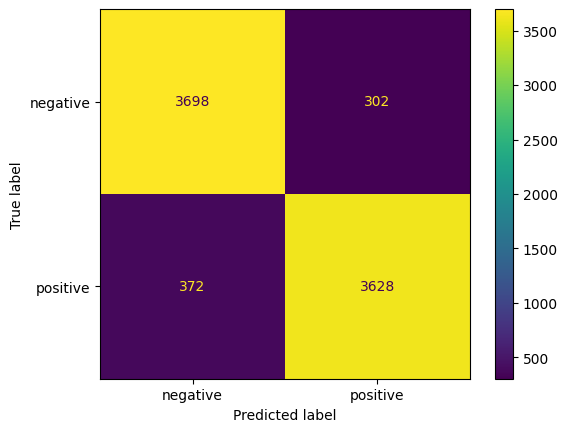

In [222]:

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["negative", "positive"])

disp.plot()
plt.show()

In [223]:
test_reviews = [
    "I hate this movie",
    "Not bad",
    "No bad",
    "I like this movie",
    "damn this movie so good, i want all the actors in this movie to fucking jump off a cliff, refund my time lil bro"
]

test_reviews = [preprocess_text(review) for review in test_reviews]
test_reviews = [extract_features(review, positive_words, negative_words, vectorizer=vectorizer) for review in test_reviews]
test_reviews = np.array([feature_to_vector(review, vectorizer=True) for review in test_reviews])

print(model.predict_proba(test_reviews))

1/1 [==============================] - 0s 61ms/step
[[[0, 0.903915], [1, 0.096085034]], [[0, 0.9736736], [1, 0.026326444]], [[0, 0.9736736], [1, 0.026326444]], [[0, 0.75671166], [1, 0.24328832]], [[0, 0.14527869], [1, 0.8547213]]]


[[[0.         0.90391499]
  [1.         0.09608503]]

 [[0.         0.97367358]
  [1.         0.02632644]]

 [[0.         0.97367358]
  [1.         0.02632644]]

 [[0.         0.75671166]
  [1.         0.24328832]]

 [[0.         0.14527869]
  [1.         0.85472131]]]